In [1]:
from autolens import conf
from autolens.autofit import non_linear
from autolens.pipeline import phase as ph
from autolens.lensing import galaxy_model as gm
from autolens.imaging import image as im
from autolens.profiles import light_profiles as lp
from autolens.profiles import mass_profiles as mp
from autolens.plotting import imaging_plotters
from autolens.plotting import fitting_plotters
from howtolens.simulations import lens_modeling as sim

# In this example, we're going to take an image and find a lens model that provides a good fit to it and we're going 
# to do this without any knowledge of what the 'correct' lens model is. 

# So, what do I mean by a 'lens model'? The lens model is the combination of light profiles and mass profiles we use to 
# represent lens galaxy, source galaxy and therefore create a tracer. Thus, to begin, we have to choose the 
# parametrization of our lens model. We don't need to specify the values of its light and mass profiles (e.g. the
# centre, einstein_radius, etc.) - only the profiles are. In this example, we'll use the following lens model:

# 1) A spherical Isothermal Sphere (SIS) for the lens galaxy's mass.
# 2) A spherical exponential light profile for the source galaxy's light.

# I'll let you into a secret - this is the same lens model that I used to simulate the image we'll fit (but I'm not
# going to tell you the actual parameters I used!).

# So, how do we infer these parameters? Well, we could randomly guess a lens model, corresponding to some
# random set of parameters. We could use this lens model to create a tracer and fit the image-data, and quantify how
# good the fit was using its likelihood (we inspected this in previous tutorial). If we kept guessing lens
# models, eventually we'd find one that provides a good fit (i.e. high likelihood) to the data!

# It may sound nuts, but this is actually the basis of how lens modeling works. However, we do a lot better than
# random guessing. Instead, we track the likelihood of our previous guesses, and guess more models using combinations
# of parameters that gave higher likelihood solutions previously. The idea is that if a set of parameters provided a 
# good fit to the data, another set with similar values probably will too.

# This is called 'non-linear search' and its a fairly common analysis found in science. Over the next few tutorials, 
# we're going to really get our heads around the concept of a non-linear search - this intuition will prove crucial 
# in being a successful lens modeler.

# We're going to use a non-linear search called 'MultiNest'. I highly recommend it, and find its great for lens 
# modeling. However, for now, lets not worry about the details of how MultiNest actually works. Instead, just
# picture that a non-linear search in PyAutoLens operates as follows:

# 1) Randomly guess a lens model and use its light-profiles and mass-profiles to set up a lens galaxy, source galaxy 
#    and a tracer.

# 2) Pass this tracer through the fitting module, generating a model image and comparing this model image to the
#    observed strong lens imaging data. This means that we've computed a likelihood.

# 3) Repeat this many times, using the likelihoods of previous fits (typically those with a high likelihood) to
#    guide us to the lens models with the highest liikelihood.

In [2]:
# We'll use the path to howtolens multiple times, so make sure you set it upt correctly!
path = 'path/to/AutoLens/howtolens/2_lens_modeling'

In [3]:
# You're going to see a line like this in every tutorial this chapter. I recommend that for now you just ignore it.
# A non-linear search can take a long time to run (minutes, hours, or days), and this isn't ideal if you want to
# go through the tutorials without having to constant stop for long periods!

# This line over-rides the configuration of the non-linear search such that it computes the solution really fast. To
# do this, I've 'cheated' - I've computed the solution myself and then input it into the config. Nevertheless, it means
# things will run fast for you, meaning you won't suffer long delays doin the tutorials.
#
# This will all become clear at the end of the chapter, so for now just bare in mind that we are taking a short-cut
# to get our non-linear search to run fast!
conf.instance = conf.Config(config_path=path+'/configs/1_non_linear_search', output_path=path+"output")

In [4]:
# In the file 'howtolens/simulations/lens_modeling', we've created functions to simulate the images we'll fit in this
# chapter. Lets simulate the image for this tutorial - it'll output this to fits files for us to load.
sim.tutorial_1_image()

In [8]:
# These are the fits file of the image the function above generated.
image = im.load_imaging_from_path(image_path=path+'data/1_non_linear_search/image.fits',
                                  noise_map_path=path+'data/1_non_linear_search/noise_map.fits',
                                  psf_path=path+'data/1_non_linear_search/psf.fits', pixel_scale=0.1)
imaging_plotters.plot_image_subplot(image=image)


FileNotFoundError: [Errno 2] No such file or directory: 'path/to/AutoLens/howtolens/2_lens_modelingdata/1_non_linear_search/image.fits'

In [5]:
# A GalaxyModel behaves analogously to the Galaxy objects we're now used to. However, whereas for a Galaxy we
# manually specified the value of every parameter of its light-profiles and mass-profiles, for a GalaxyModel
# these are inferred by the non-linear search.

# Lets model the lens galaxy with an SIS mass profile (which is what it was simulated with).
lens_galaxy_model = gm.GalaxyModel(mass=mp.SphericalIsothermal)

In [6]:
# Lets model the source galaxy with a spherical exponential light profile (again, what it was simulated with).
source_galaxy_model = gm.GalaxyModel(light=lp.SphericalExponential)

In [9]:
# A phase takes our galaxy models and fits their parameters via a non-linear search (in this case, MultiNest). In this
# example, we have a lens-plane and source-plane, so we use a LensSourcePlanePhase.

# (Just like we could give profiles descriptive names, like 'light', 'bulge' and 'disk', we can do the exact same
# thing with galaxies. This is very good practise - as once we start using complex lens models, you could potentially
# have a lot of galaxies - and this is the best way to keep track of them!)

# (also, just ignore the 'dict' - its necessary syntax but not something you need to concern yourself with)

phase = ph.LensSourcePlanePhase(lens_galaxies=dict(lens_galaxy=lens_galaxy_model),
                                source_galaxies=dict(source_galaxy=source_galaxy_model),
                                optimizer_class=non_linear.MultiNest,
                                phase_name='1_non_linear_search')

NameError: name 'lens_galaxy_model' is not defined

In [8]:
# To run the phase, we simply pass it the image data we want to fit, and the non-linear search begins! As the phase
# runs, a logger will show you the parameters of the best-fit model.
results = phase.run(image)

DEBUG:autolens.pipeline.phase:
Running lens/source lensing for... 

Lens Galaxy:
[Redshift: Constant 1
Mass Profiles:
SphericalIsothermal
centre: (-0.003318326859910504, 0.014313042803659132)
axis_ratio: 1.0
phi: 0.0
einstein_radius: 1.6003157699592232
slope: 2.0
core_radius: 0.0]

Source Galaxy:
[Redshift: Constant 1
Light Profiles:
SphericalExponential
centre: (-0.0011182112586929699, 0.0006903404255652239)
axis_ratio: 1.0
phi: 0.0
intensity: 0.20100433027858072
effective_radius: 0.1954737089453587
sersic_index: 1.0]




/home/jammy/PyCharm/Projects/AutoLens/howtolens/2_lens_modeling/../output/2_lens_modeling/1_non_linear_search/optimizer/multinest.txt
Removed no burn in


In [9]:
# Now this has run you should checkout the 'AutoLens/output/howtolens' folder. This is where the results of the phase 
# are written to your hard-disk (in the '1_non_linear_search' folder). When its completed, images and output will also 
# appear in this folder, meaning that you don't need to keep running python code to see the results.

# We can print the results to see the best-fit model parameters
# print(results) # NOTE - this isn't working yet, need to sort out.

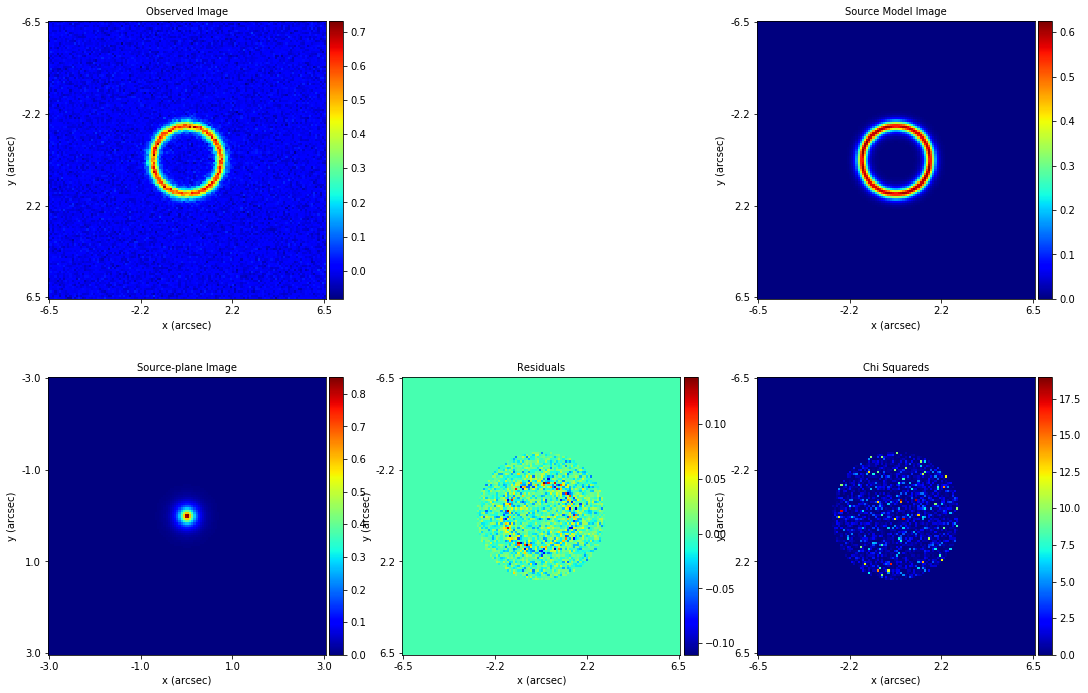

In [10]:
# The best-fit solution (i.e. the highest likelihood) is stored in the 'results', which we can plot as per usual.
fitting_plotters.plot_fitting_subplot(fit=results.fit)

In [15]:
# The fit looks good, and we've therefore found a model pretty close to the one we simulated the image with (you can 
# confirm this yourself if you want, by comparing the inferred parameters to those found in the simulations.py file).

# And with that, we're done - you've successfully modeled your first strong lens with PyAutoLens! Before moving
# onto the next tutorial, I want you to think about the following:

# 1) a non-linear search is often said to search a 'non-linear parameter-space' - why is the term parameter-space used?

# 2) Why is this parameter space 'non-linear'?

# 3) Initially, the non-linear search randomly guesses the values of the parameters. However, it shouldn't 'know' what
#    reasonable values for a parameter are. For example, it doesn't know that a reasonable Einstein radius is between 
#    0.0" and 4.0"). How does it know what are reasonable values of parameters to guess?